# # Homework: Week 4
Orhan Soyuhos

In [4]:
import json
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy import stats
from sklearn.decomposition import PCA

## -> Dataset 

In [5]:
# Python: Reading JSON

#open file
f = open('hw4.json')
example_data = json.load(f)
f.close()

events_data = example_data['events']
neurons_data = example_data['neurons']

In [6]:
events_data.keys(), len(neurons_data.keys()), neurons_data.keys()

(dict_keys(['event_1', 'event_2', 'event_3', 'event_4']),
 29,
 dict_keys(['sig001a', 'sig002a', 'sig002b', 'sig002c', 'sig003a', 'sig003b', 'sig004a', 'sig004b', 'sig005a', 'sig005b', 'sig006a', 'sig006b', 'sig006c', 'sig007a', 'sig007b', 'sig007c', 'sig008a', 'sig008b', 'sig008c', 'sig009a', 'sig010a', 'sig010b', 'sig011a', 'sig012a', 'sig013a', 'sig014a', 'sig015a', 'sig016a', 'sig016b']))

## -> Store the data  

In [7]:
class neuron:
    def __init__(self, name, neurons_data, events_data):
        self.name = name
        self.neuron_data = np.array(neurons_data[name])
        self.events_data = np.array(events_data)
        
    def relative_spike(self):
        events_data_typeList = self.events_data.tolist()
        neuron_data = self.neuron_data
        relative_spikes = dict()
        
        for key, value in events_data_typeList.items():
            tmp_data = list()
            for event_time in value:
                tmp_data.append(list(neuron_data - event_time))
                relative_spikes[key] = tmp_data
                
        return relative_spikes
    
    def relative_response_matrix(self, bin_size):
        relative_spikes = self.relative_spike()
        rrm = dict() 
        
        for event_key, relative_spikes in relative_spikes.items():            
            rrm[event_key] = []
            for relative_spike in relative_spikes:
                response_start = 0
                response_end = 0.2
                response_window = list(np.arange(response_start, response_end, bin_size))
                total_bins = len(response_window)
                binned_spikes = np.histogram(relative_spike, total_bins, range = (response_start, response_end))[0]
                rrm[event_key].append(binned_spikes)

        return rrm
    
    def PSTH_template(self, bin_size):
        rrm = self.relative_response_matrix(bin_size)
        PSTH_template = dict()
        
        for event_key, rrm_value in rrm.items():   
            PSTH_template[event_key] = rrm_value

        return PSTH_template

In [8]:
class events:
    def __init__(self, neurons_data, events_data):
        self.neurons_data = neurons_data
        self.events_data = events_data
        
    def PSTH_templates(self, bin_size):        
        PSTH_templates = dict()    
        events_data = self.events_data
        neurons_data = self.neurons_data
        
        for event_key, event_value in events_data.items():
            PSTH_template = []
            for neuron_key, neuron_value in neurons_data.items():
                neuron_class = neuron(neuron_key, neurons_data, events_data)
                tmp_template = neuron_class.PSTH_template(bin_size)
                PSTH_template.append(tmp_template[event_key])
            PSTH_templates[event_key] = np.array(PSTH_template)
            
        return PSTH_templates

In [9]:
all_events = events(neurons_data, events_data)

#select: 0.001
PSTH_templates_0001 = all_events.PSTH_templates(0.001)

In [10]:
PSTH_templates_0001.keys()

dict_keys(['event_1', 'event_2', 'event_3', 'event_4'])

## -> Part 1: Creating the PCA Input
multineural timeseries (MNTS)

In [11]:
PSTH_templates_0001['event_2'].shape

(29, 77, 200)

In [12]:
class MNTS:
    def __init__(self, PSTH_templates):
        
        # multineural timeseries (MNTS)
        event_1 = PSTH_templates['event_1']
        event_2 = PSTH_templates['event_2']
        event_3 = PSTH_templates['event_3']
        event_4 = PSTH_templates['event_4']
        events = np.concatenate((event_1, event_2, event_3, event_4), axis = 1)
        MNTS = events.reshape([len(events), -1]).T
        
        self.MNTS = MNTS
        self.events = events
        
    def MNTS_shape(self):    
        MNTS = self.MNTS
        return np.array(MNTS).shape
        
    def events_shape(self):    
        events = self.events
        return np.array(events).shape

    def value(self):    
        MNTS = self.MNTS
        return MNTS
    
    def zscore(self):
        MNTS = self.MNTS
        mnts_zscore = stats.zscore(MNTS, axis=0, ddof = 1)
        mnts_zscore[np.isnan(mnts_zscore)] = 0
        
        return mnts_zscore
    
    def pca(self):
        mnts_zscore = self.zscore()
            
        mnts_pca = PCA()
        mnts_pca.fit(mnts_zscore)
        
        mnts_projection = mnts_pca.transform(mnts_zscore)
        eigenvalues = mnts_pca.explained_variance_.tolist()
        pc_variance = (mnts_pca.explained_variance_ratio_ * 100).tolist()
        
        return eigenvalues, pc_variance, mnts_projection

In [13]:
MNTS_0001 = MNTS(PSTH_templates_0001)
MNTS_0001.MNTS_shape()

(60000, 29)

In [14]:
MNTS_0001.zscore().T.shape

(29, 60000)

In [15]:
pca_input = dict()
ii = 0
for neuron_key in neurons_data.keys():
    pca_input[neuron_key] = np.unique(MNTS_0001.zscore().T[ii]).tolist()
    ii += 1

## -> Part 2: PCA
multineural timeseries (MNTS)

In [16]:
eigenvalues, pc_variance, mnts_projection = MNTS_0001.pca()
len(eigenvalues)

29

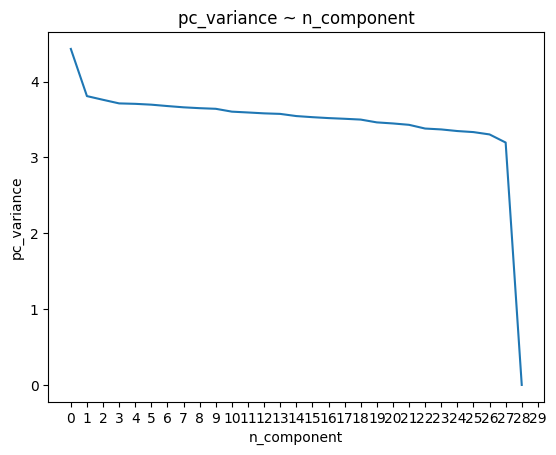

In [56]:
plt.plot(pc_variance)
plt.ylabel('pc_variance')
plt.xlabel('n_component')
plt.xticks(np.arange(0, 29+1, 1))
plt.title('pc_variance ~ n_component')
plt.savefig('pc_variance.png')

In [17]:
mnts_projection.shape

(60000, 29)

In [18]:
n_components = 4
mnts_projection[:,:n_components].shape

(60000, 4)

## -> Part 3: Plotting


In [19]:
nTrial = MNTS_0001.events_shape()[1]
nBins = MNTS_0001.events_shape()[2]
nTrial, nBins

(300, 200)

In [21]:
n1 = PSTH_templates_0001['event_1'].shape[1]
n2 = n1 + PSTH_templates_0001['event_2'].shape[1]
n3 = n2 + PSTH_templates_0001['event_3'].shape[1]
n4 = n3 + PSTH_templates_0001['event_4'].shape[1]

In [22]:
mnts_projection_T = mnts_projection[:, :n_components].T
mnts_projection_reshaped = mnts_projection_T.reshape(n_components, nTrial, nBins)

pc_event = dict()
pc_event['pc_event1'] = mnts_projection_reshaped[:, :n1, :]
pc_event['pc_event2'] = mnts_projection_reshaped[:, n1:n2, :]
pc_event['pc_event3'] = mnts_projection_reshaped[:, n2:n3, :]
pc_event['pc_event4'] = mnts_projection_reshaped[:, n3:n4, :]

ev_psth = dict()
ev_psth['ev_1_psth'] = np.mean(pc_event['pc_event1'], axis=1)
ev_psth['ev_2_psth'] = np.mean(pc_event['pc_event2'], axis=1)
ev_psth['ev_3_psth'] = np.mean(pc_event['pc_event3'], axis=1)
ev_psth['ev_4_psth'] = np.mean(pc_event['pc_event4'], axis=1)

/var/folders/1j/r5d3f6351yd2fkfgn9dl6mwh0000gq/T/ipykernel_17705/3886243689.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + xticklabels_str + [''])


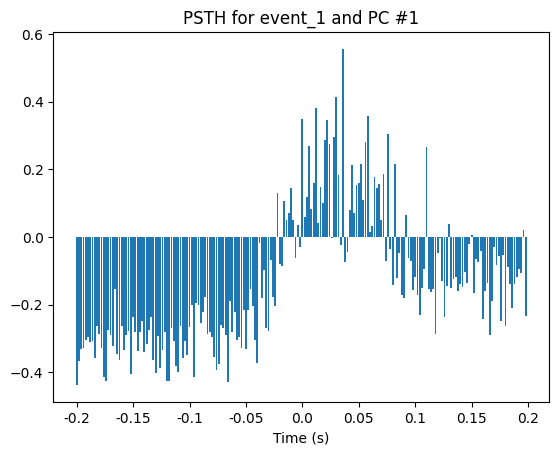

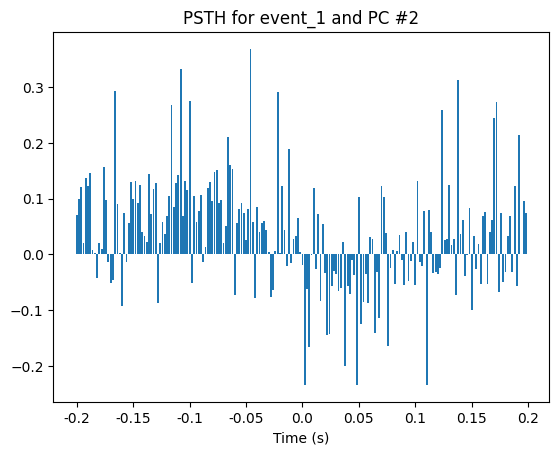

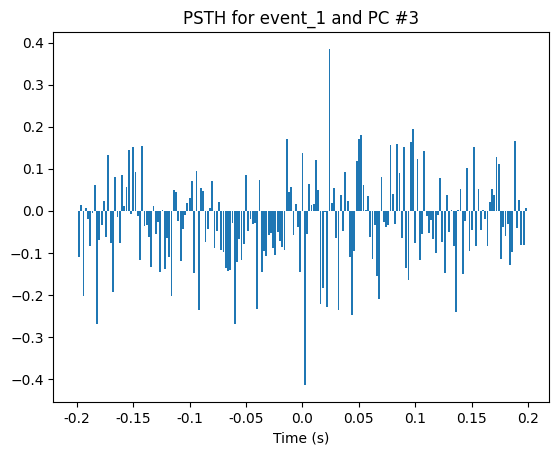

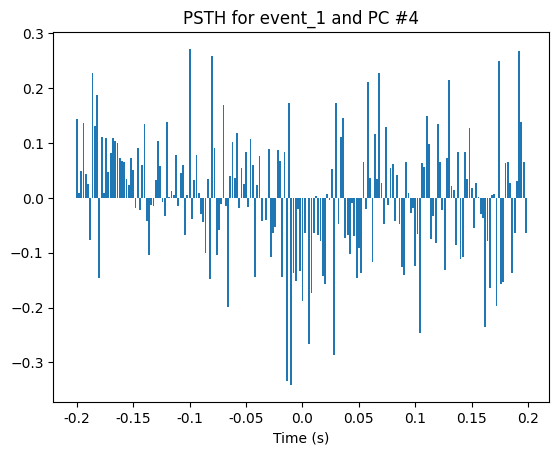

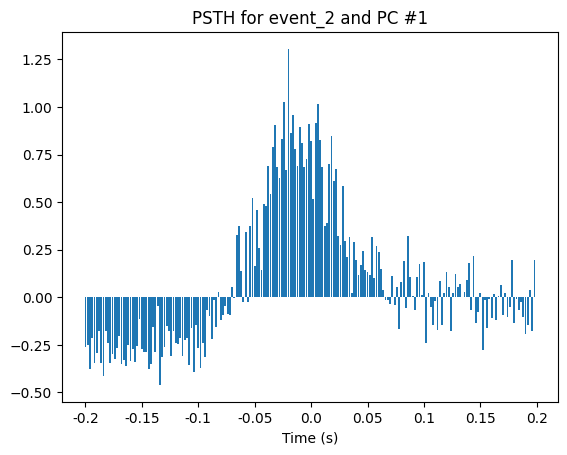

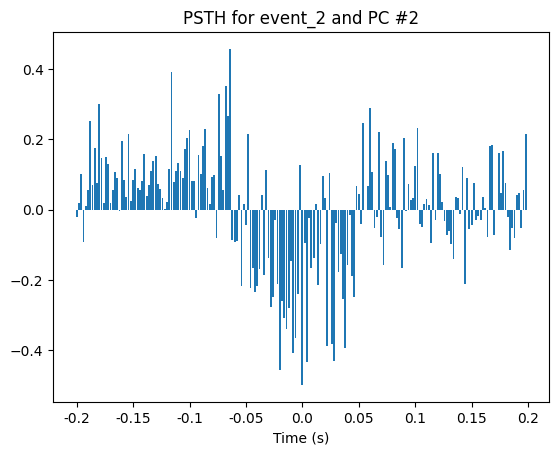

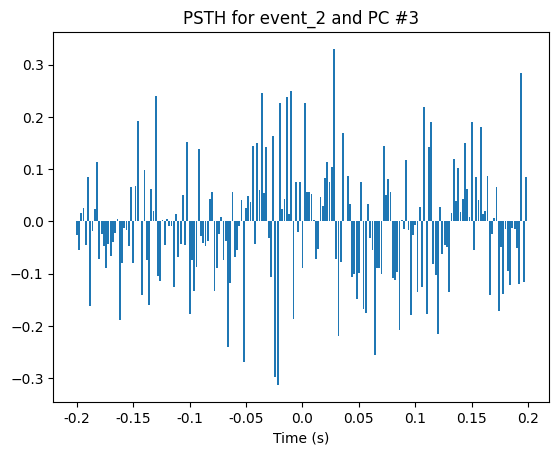

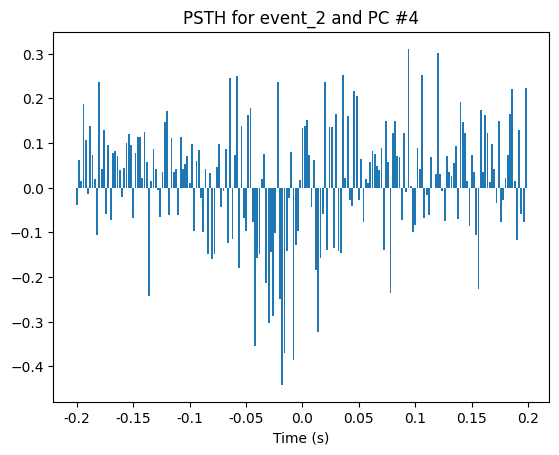

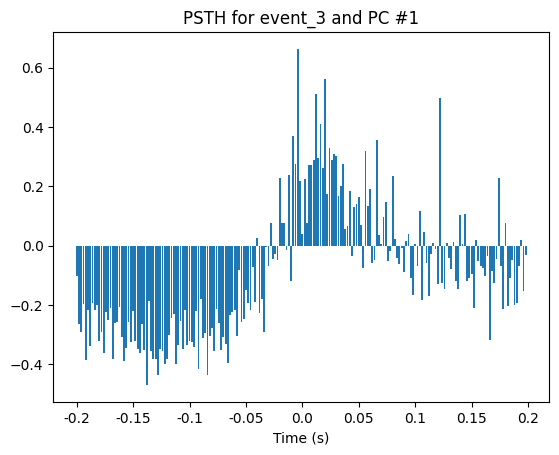

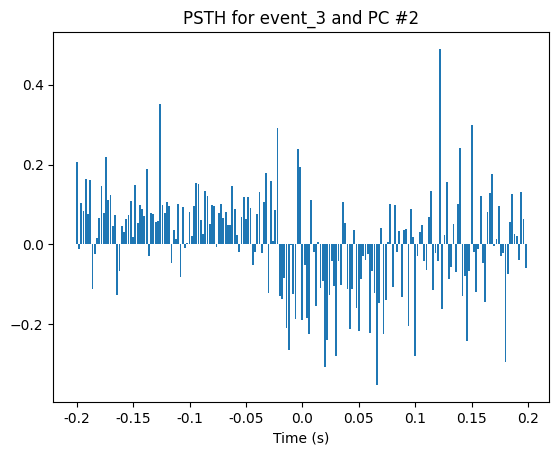

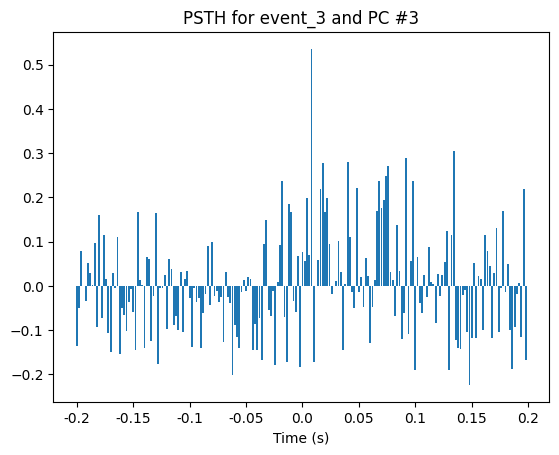

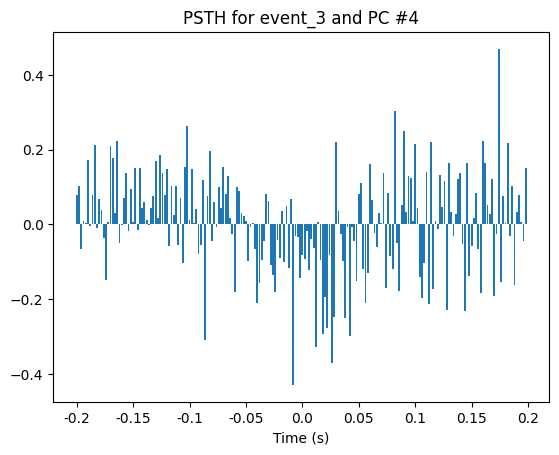

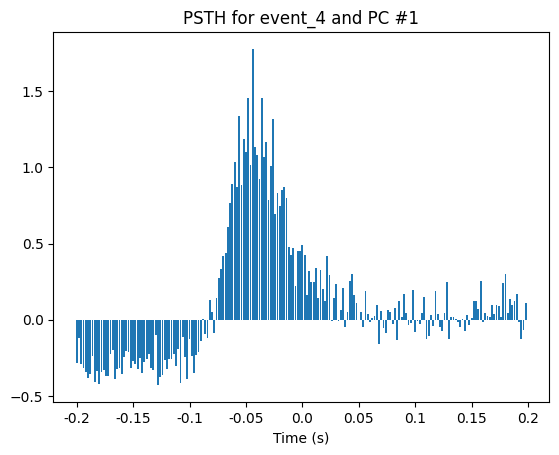

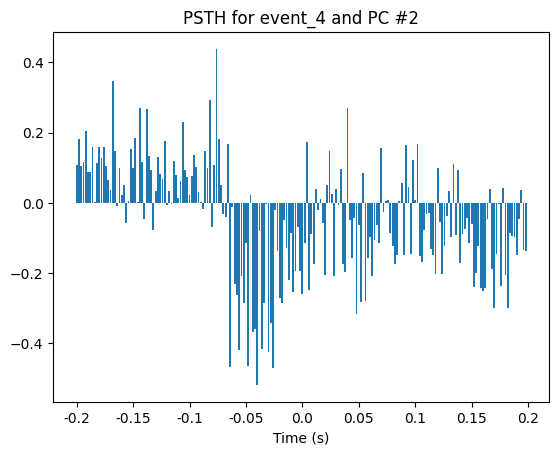

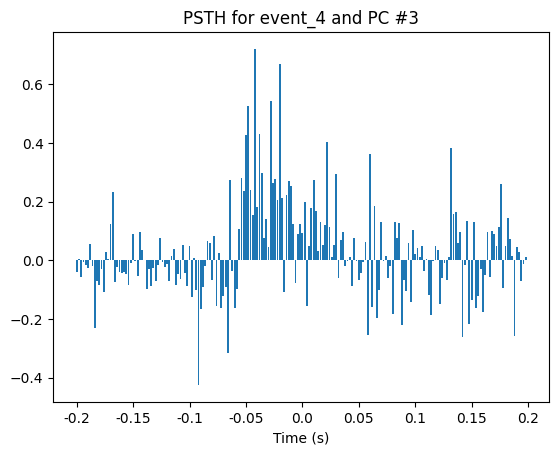

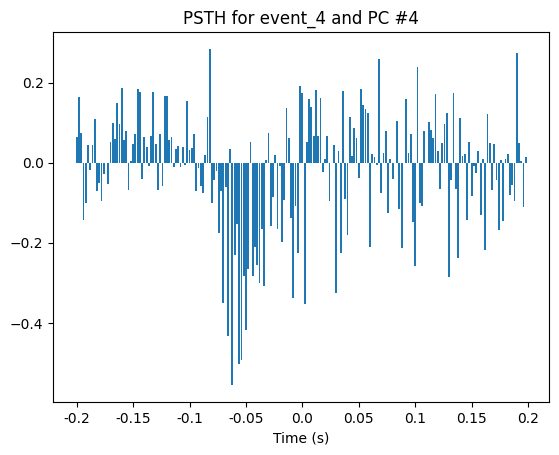

In [29]:
for ev_n in range(1,5):
    for pca_n in range(0,4):
        fig, ax = plt.subplots()

        selected_ev = ev_psth[f'ev_{ev_n}_psth']
        ax.bar(range(len(selected_ev[pca_n])), selected_ev[pca_n])

        ax.set_xlabel('Time (s)')
        ax.set_title(f'PSTH for event_{ev_n} and PC #{pca_n+1}')

        baseline_start = -0.2
        response_end = 0.2

        xticklabels = np.linspace(baseline_start, response_end, len(ax.get_xticklabels())-2)
        xticklabels_str = []
        for xticklabel in xticklabels:
            xticklabels_str.append(str(round(xticklabel,2)))
        xticklabels_str
        ax.set_xticklabels([''] + xticklabels_str + [''])

        plt.show()
        fig.savefig(f'event_{ev_n}_pc_{pca_n+1}_psth.png')
    

## -> Part 4: Classification Analysis


### # Creating the Classifier

In [33]:
pc_event['pc_event1'].shape

(4, 71, 200)

In [34]:
def X_events(pc_event):

    event_1_T = np.transpose(pc_event['pc_event1'], (1,0,2))
    event_2_T = np.transpose(pc_event['pc_event2'], (1,0,2))
    event_3_T = np.transpose(pc_event['pc_event3'], (1,0,2))
    event_4_T = np.transpose(pc_event['pc_event4'], (1,0,2))

    X = dict()
    X['event_1_T'] = event_1_T
    X['event_2_T'] = event_2_T
    X['event_3_T'] = event_3_T
    X['event_4_T'] = event_4_T
    
    return X

In [35]:
X = X_events(pc_event)

In [36]:
class classifier:
    def __init__(self, X):
        self.event_1 = X['event_1_T'] 
        self.event_2 = X['event_2_T'] 
        self.event_3 = X['event_3_T']
        self.event_4 = X['event_4_T']
        self.temp_1 = np.mean(self.event_1, 0)
        self.temp_2 = np.mean(self.event_2, 0)
        self.temp_3 = np.mean(self.event_3, 0)
        self.temp_4 = np.mean(self.event_4, 0)

    def leave_one_out(self): 
        y_hats = []
        for i in range(len(self.event_1)):    
            left_out = self.event_1[i]
            train_1 = np.delete(self.event_1, i, axis = 0)
            temp_1 = np.mean(train_1, 0)
            dist_1 = self.measure_dist(left_out, temp_1)
            dist_2 = self.measure_dist(left_out, self.temp_2)
            dist_3 = self.measure_dist(left_out, self.temp_3)
            dist_4 = self.measure_dist(left_out, self.temp_4)
            distances = np.append([], [dist_1, dist_2, dist_3, dist_4])
            min_idx = distances.tolist().index(min(distances))
            y_hats.append(self.predict(min_idx))

        for i in range(len(self.event_2)):    
            left_out = self.event_2[i]
            train_3 = np.delete(self.event_2, i, axis = 0)
            temp_2 = np.mean(train_3, 0)
            dist_1 = self.measure_dist(left_out, self.temp_1)
            dist_2 = self.measure_dist(left_out, temp_2)
            dist_3 = self.measure_dist(left_out, self.temp_3)
            dist_4 = self.measure_dist(left_out, self.temp_4)
            distances = np.append([], [dist_1, dist_2, dist_3, dist_4])
            min_idx = distances.tolist().index(min(distances))
            y_hats.append(self.predict(min_idx))
            
        for i in range(len(self.event_3)):    
            left_out = self.event_3[i]
            train_4 = np.delete(self.event_3, i, axis = 0)
            temp_3 = np.mean(train_4, 0)
            dist_1 = self.measure_dist(left_out, self.temp_1)
            dist_2 = self.measure_dist(left_out, self.temp_2)
            dist_3 = self.measure_dist(left_out, temp_3)
            dist_4 = self.measure_dist(left_out, self.temp_4)
            distances = np.append([], [dist_1, dist_2, dist_3, dist_4])
            min_idx = distances.tolist().index(min(distances))
            y_hats.append(self.predict(min_idx))
            
        for i in range(len(self.event_4)):    
            left_out = self.event_4[i]
            train_6 = np.delete(self.event_4, i, axis = 0)
            temp_4 = np.mean(train_6, 0)
            dist_1 = self.measure_dist(left_out, self.temp_1)
            dist_2 = self.measure_dist(left_out, self.temp_2)
            dist_3 = self.measure_dist(left_out, self.temp_3)
            dist_4 = self.measure_dist(left_out, temp_4)
            distances = np.append([], [dist_1, dist_2, dist_3, dist_4])
            min_idx = distances.tolist().index(min(distances))
            y_hats.append(self.predict(min_idx))
                
        return y_hats

    def predict(self, min_idx):        
        if min_idx == 0:
            y_hat = 1
        elif min_idx == 1:
            y_hat = 2
        elif min_idx == 2:
            y_hat = 3
        elif min_idx == 3:
            y_hat = 4
        return y_hat
    
    def measure_dist(self, x, y):
        distance = np.linalg.norm(np.array(x) - np.array(y))
        return distance

In [37]:
labels = [1]*X['event_1_T'].shape[0] + [2]*X['event_2_T'].shape[0] + [3]*X['event_3_T'].shape[0] + [4]*X['event_4_T'].shape[0]

In [38]:
y_hats = classifier(X).leave_one_out()

### # Confusion Matrix and Accuracy

In [39]:
result_confusion = confusion_matrix(labels, y_hats)
result_confusion

array([[46,  3, 22,  0],
       [13, 32, 14, 18],
       [37,  6, 28,  1],
       [ 2, 15,  7, 56]])

In [40]:
accuracy = accuracy_score(labels, y_hats)
accuracy

0.54

### # Mutual Information

In [41]:
def mutual_info_(result_confusion):

    row_entropy = []
    total = sum(sum(result_confusion))
    for i in range(len(result_confusion)):
        row = 0
        for j in range(len(result_confusion)):
            row += result_confusion[i][j]
        row_entropy.append(row)


    col_entropy = []
    ele_e = 0
    for i in range(len(result_confusion)):
        col = 0
        for j in range(len(result_confusion)):
            e = result_confusion[j][i]/total
            if e != 0:
                ele_e += e * math.log(e, 2)
            col += result_confusion[j][i]
        col_entropy.append(col)


    row_e = 0
    col_e = 0
    for i in range(len(col_entropy)):
        r = row_entropy[i]/total
        c = col_entropy[i]/total
        col_e += c * math.log(c, 2)
        row_e += r * math.log(r, 2)

    row_e = row_e * -1
    col_e = col_e * -1
    ele_e = ele_e * -1

    mutual_info = col_e + row_e - ele_e

    return mutual_info

In [42]:
mutual_info = mutual_info_(result_confusion)
mutual_info

0.5466034581347525

## # Save to JSON file

In [45]:
hw4_results = dict()

hw4_results['eigenvalues'] = eigenvalues
hw4_results['pc_variance'] = pc_variance
hw4_results['pca_input'] = pca_input
hw4_results['psth_classifier'] = dict()
hw4_results['psth_classifier']['confusion_matrix'] = result_confusion.tolist()
hw4_results['psth_classifier']['mutual_info'] = mutual_info
hw4_results['psth_classifier']['accuracy'] = accuracy

hw4_results['event_1'] = dict()
hw4_results['event_1']['pc_1_psth'] = ev_psth['ev_1_psth'][0].tolist()
hw4_results['event_1']['pc_2_psth'] = ev_psth['ev_1_psth'][1].tolist()
hw4_results['event_1']['pc_3_psth'] = ev_psth['ev_1_psth'][2].tolist()
hw4_results['event_1']['pc_4_psth'] = ev_psth['ev_1_psth'][3].tolist()

hw4_results['event_2'] = dict()
hw4_results['event_2']['pc_1_psth'] = ev_psth['ev_2_psth'][0].tolist()
hw4_results['event_2']['pc_2_psth'] = ev_psth['ev_2_psth'][1].tolist()
hw4_results['event_2']['pc_3_psth'] = ev_psth['ev_2_psth'][2].tolist()
hw4_results['event_2']['pc_4_psth'] = ev_psth['ev_2_psth'][3].tolist()

hw4_results['event_3'] = dict()
hw4_results['event_3']['pc_1_psth'] = ev_psth['ev_3_psth'][0].tolist()
hw4_results['event_3']['pc_2_psth'] = ev_psth['ev_3_psth'][1].tolist()
hw4_results['event_3']['pc_3_psth'] = ev_psth['ev_3_psth'][2].tolist()
hw4_results['event_3']['pc_4_psth'] = ev_psth['ev_3_psth'][3].tolist()

hw4_results['event_4'] = dict()
hw4_results['event_4']['pc_1_psth'] = ev_psth['ev_4_psth'][0].tolist()
hw4_results['event_4']['pc_2_psth'] = ev_psth['ev_4_psth'][1].tolist()
hw4_results['event_4']['pc_3_psth'] = ev_psth['ev_4_psth'][2].tolist()
hw4_results['event_4']['pc_4_psth'] = ev_psth['ev_4_psth'][3].tolist()

In [46]:
with open('Soyuhos_Orhan_hw4.json', 'w') as f_out:
    json.dump(hw4_results, f_out, indent=4, sort_keys=True)